This code is made by Chas (and AlexR) and was modified for python3 by AlexF
In-n-Out in progress

In [1]:
import numpy as np
import pickle as pickle
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
from tqdm import tqdm
import multiprocessing as mp


In [2]:
# bead radius [µm] (certain it shouldn't be diameter)
rbead = 2.4e-6 #float(sys.argv[1])
# position relative to the attractor center
cent_pos = 0.0e-6 #float(sys.argv[2])
# difference in height of attractor and bead [µm]
height = 0 #float(sys.argv[3])

# load the density profile of the attractor (took the one AlexR and Chas have produced)
rhopath = '/home/analysis_user/Results/Sensitivity/rho_arr.p' 
rho, xx, yy, zz = pickle.load(open(rhopath, 'rb'), encoding="latin1") # first change, encoding to latin1 instead of ASCII
print("Density Loaded.")
sys.stdout.flush()

Density Loaded.


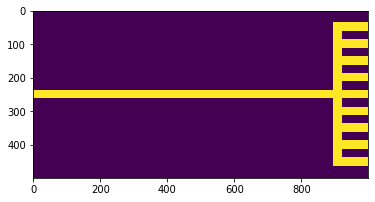

In [3]:
plt.imshow(rho[0:499,0:999,int(.5*len(zz))]) # show the attractor

In [4]:
xx = np.array(xx) # maxe array for x
yy = np.array(yy) # make array for y
zz = np.array(zz) # make array for z

xinds = np.abs(xx) <= 25.0e-6 # width you want to simulate (25e-6)
yinds = np.abs(yy) <= 80.0e-6 # length of the attractor in y you want to use (~80 if only the finger)
zinds = np.abs(zz) <= 5.0e-6 # thickness should be complete finger

xinds = np.abs(xx) <= 25.0e-6 # width you want to simulate (25e-6)
yinds = np.abs(yy) <= 80.0e-6 # length of the attractor in y you want to use (~80 if only the finger)
zinds = np.abs(zz) <= 5.0e-6 # thickness should be complete finger



xx2 = xx[xinds] # reduce the xx array to your selection (symmetric) 
yy2 = yy[yinds] # reduce the yy array to your selection
zz2 = zz[zinds] # zz2 is the entire thickness
rho2 = rho[xinds,:,:][:,yinds,:] # density of a finger


# produce empty arrays 

xzeros = np.zeros(len(xx))
yzeros = np.zeros(len(yy))
zzeros = np.zeros(len(zz))

xzeros2 = np.zeros(len(xx2))
yzeros2 = np.zeros(len(yy2))
zzeros2 = np.zeros(len(zz2))

dx = np.abs(xx[1] - xx[0]) # smallest step in x
dy = np.abs(yy[1] - yy[0]) # smallest step in y
dz = np.abs(zz[1] - zz[0]) # smallest step in z

cell_volume = dx * dy * dz # volume of a cell for the calculation
m = rho * cell_volume # calculate into mass for the entire attractor
m2 = rho2 * cell_volume # calculate into mass for the selection

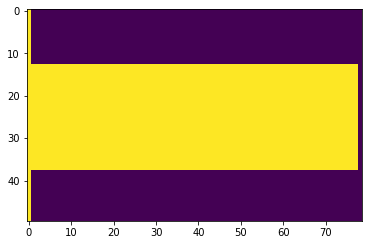

In [5]:
plt.imshow(rho2[:, :, 5])

In [6]:
G = 6.67e-11     # m^3 / (kg s^2)
rhobead = 1550. # updated value from mass paper

travel = 500e-6 # travel
Npoints = 11 # how many points for each direction 
beadposvec = np.linspace(cent_pos - travel*0.5, cent_pos + travel*0.5, Npoints) # position vector for the position along the detector
beadposvec2 = np.linspace(0, travel, (Npoints-1) + 1) # movement along the y axis for the bead

lambdas = np.logspace(-6.3, -3, 100)  # make lambda for yukawa scan
lambdas = lambdas[::-1] # make lambda

In [7]:
# where to put the results and how to name them

respath = 'results/'
respath = respath + 'rbead_' + str(rbead)
respath = respath + '_centpos_' + str(cent_pos)
respath = respath + '_height_' + str(height)
respath = respath + '.p'
results_dic = {}
results_dic['order'] = 'Rbead, Cent_pos, Height, Yuklambda'

In [8]:
finger_inds = np.array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]) # indicator for the finger with

def find_ind(pos): # define the boundaries of the fingers starting from the center 
    if np.abs(pos) <= 25e-6:
        ind = 0
    elif np.abs(pos) > 25e-6:
        if np.abs(pos) <= 75e-6:
            if pos > 0: # positive side
                ind = 1.0
            elif pos < 0:
                ind = -1.0 #negative side
        elif np.abs(pos) > 75e-6:
            if np.abs(pos) <= 125e-6:
                if pos > 0:
                    ind = 2.0
                if pos < 0:
                    ind = -2.0
            elif np.abs(pos) > 125e-6:
                if np.abs(pos) <= 175e-6:
                    if pos > 0:
                        ind = 3.0
                    if pos < 0:
                        ind = -3.0
                elif np.abs(pos) > 175e-6:
                    if pos > 0:
                        ind = 4.0
                    if pos < 0:
                        ind = -4.0

    newpos = pos - ind * 50e-6 # define the position such that its always relative to a finger

    return ind, newpos


def dist(p1, p2): 
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2) # distance, not used in the code

def dist_p_arrp(p1, xs, ys, zs): # distance in three dimensions
    xnew = (xs - p1[0])**2
    ynew = (ys - p1[1])**2
    znew = (zs - p1[2])**2
    return np.sqrt(np.add.outer(np.add.outer(xnew, ynew), znew))

In [12]:
# initilaize the dictionaries 
results_dic[rbead] = {}
results_dic[rbead][cent_pos] = {}
results_dic[rbead][cent_pos][height] = {}


Gterm = 2. * rbead**3

GforcecurveX = []
GforcecurveY = []
GforcecurveZ = []
    


In [13]:
for ind, ypos in enumerate(tqdm(beadposvec2)):
    beadpos = [cent_pos, ypos+rbead, height] # definde the bead position, only the separation can change, y is to the bead center
    s = dist_p_arrp(beadpos, xx, yy, zz) - rbead # calculate the distance surface to surface

    # These are used to compute projections and thus need to maintain sign
    xsep = dist_p_arrp([cent_pos, 0, 0], xx, yzeros, zzeros)
    xind = np.argmin(np.abs(xx - 0))
    xsep[:xind,:,:] *= -1.0

    # We a priori know that all yseps should be negative
    ysep = dist_p_arrp([0, rbead+ypos, 0], xzeros, yy, zzeros)
    ysep *= -1.0

    zsep = dist_p_arrp([0, 0, height], xzeros, yzeros, zz)
    zind = np.argmin(np.abs(zz - height))
    zsep[:,:,:zind] *= -1.0

    xprojection = xsep / (s + rbead)
    yprojection = ysep / (s + rbead)
    zprojection = zsep / (s + rbead)

    prefac = ((2. * G * m * rhobead * np.pi) / (3. * (rbead + s)**2))

    xtotforce = np.sum(prefac * Gterm * xprojection)
    ytotforce = np.sum(prefac * Gterm * yprojection)
    ztotforce = np.sum(prefac * Gterm * zprojection)


    # SWAP X AND Y AXES TO MATCH DATA AXES
    GforcecurveX.append(ytotforce)
    GforcecurveY.append(xtotforce)
    GforcecurveZ.append(ztotforce)

GforcecurveX = np.array(GforcecurveX)
GforcecurveY = np.array(GforcecurveY)
GforcecurveZ = np.array(GforcecurveZ)




100%|██████████| 11/11 [00:04<00:00,  2.61it/s]


In [14]:
for yukind, yuklambda in enumerate(tqdm(lambdas)):
    func = np.exp(-2. * rbead / yuklambda) * (1. + rbead / yuklambda) + rbead / yuklambda - 1.

    yukforcecurveX = []
    yukforcecurveY = []
    yukforcecurveZ = []
    
    for ind, ypos in enumerate(beadposvec2):

        beadpos = [cent_pos, ypos+rbead, height]

        s = dist_p_arrp(beadpos, xx, yy, zz) - rbead
        # These are used to compute projections and thus need to maintain sign
        xsep = dist_p_arrp([cent_pos, 0, 0], xx, yzeros, zzeros)
        xind = np.argmin(np.abs(xx - cent_pos))
        xsep[:xind,:,:] *= -1.0

        # We a priori know that all yseps should be negative
        ysep = dist_p_arrp([0, ypos+rbead, 0], xzeros, yy, zzeros)
        ysep *= -1.0

        zsep = dist_p_arrp([0, 0, height], xzeros, yzeros, zz)
        zind = np.argmin(np.abs(zz - height))
        zsep[:,:,:zind] *= -1.0

        xprojection = xsep / (s + rbead)
        yprojection = ysep / (s + rbead)
        zprojection = zsep / (s + rbead)

        prefac = ((2. * G * m * rhobead * np.pi) / (3. * (rbead + s)**2))

        yukterm = 3 * yuklambda**2 * (rbead + s + yuklambda) * func * np.exp( - s / yuklambda )
        #print(-s/yuklambda)
        xtotforce = np.sum(prefac * yukterm * xprojection)
        ytotforce = np.sum(prefac * yukterm * yprojection)
        ztotforce = np.sum(prefac * yukterm * zprojection)
      

        # SWAP X AND Y AXES TO MATCH DATA AXES
        yukforcecurveX.append(ytotforce) 
        yukforcecurveY.append(xtotforce)
        yukforcecurveZ.append(ztotforce)
        
    yukforcecurveX = np.array(yukforcecurveX)
    yukforcecurveY = np.array(yukforcecurveY)
    yukforcecurveZ = np.array(yukforcecurveZ)

"""   
    yukX = interp.interp1d(beadposvec2, yukforcecurveX, kind='cubic')
    yukY = interp.interp1d(beadposvec2, yukforcecurveY, kind='cubic')
    yukZ = interp.interp1d(beadposvec2, yukforcecurveZ, kind='cubic')

    newyukX = np.zeros(len(beadposvec))
    newyukY = np.zeros(len(beadposvec))
    newyukZ = np.zeros(len(beadposvec))

    for ind, pos in enumerate(beadposvec):
        if np.abs(pos) - 225e-6 > 0:
            newyukX[ind] = 0.0
            newyukY[ind] = 0.0
            newyukZ[ind] = 0.0
            continue

        finger_ind, newpos = find_ind(pos)
        width = 50.0e-6
  
        newyukX[ind] = np.sum(yukX(newpos + (finger_inds+finger_ind) * width))
        newyukY[ind] = np.sum(yukY(newpos + (finger_inds+finger_ind) * width))
        newyukZ[ind] = np.sum(yukZ(newpos + (finger_inds+finger_ind) * width))
        #print(newyukX[ind],newyukY[ind],newyukZ[ind])

"""

print("100! Done!")

100%|██████████| 100/100 [09:31<00:00,  5.84s/it]

100! Done!


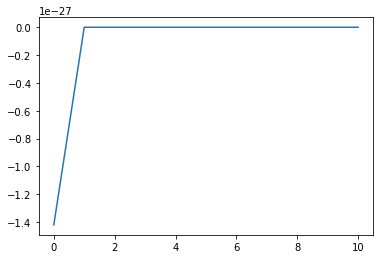

In [18]:
plt.plot(yukforcecurveX)

In [16]:
results_dic[rbead][cent_pos][height][yuklambda] = \
                (newGX, newGY, newGZ, newyukX, newyukY, newyukZ)



NameError: name 'newGX' is not defined

In [17]:
results_dic['posvec'] = beadposvec2
try:
    pickle.dump(results_dic, open(respath, 'wb') )
    print("Saved: ", respath)
except:
    print("Save didn't work!")


Save didn't work!


In [ ]:
print(respath)